# Import

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

sys.path.append('../utils/')
import utils

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context('notebook')

In [2]:
%reload_ext autoreload
%autoreload 2

# Data

In [3]:
df = pd.read_csv('../data/rent.csv')
df.shape

(49352, 15)

In [4]:
df.head(2).T

,0,1
bathrooms,1.5,1
bedrooms,3,2
building_id,53a5b119ba8f7b61d4e010512e0dfc85,c5c8a357cba207596b04d1afd1e4f130
created,2016-06-24 07:54:24,2016-06-12 12:19:27
description,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,
display_address,Metropolitan Avenue,Columbus Avenue
features,[],"['Doorman', 'Elevator', 'Fitness Center', 'Cat..."
interest_level,medium,low
latitude,40.7145,40.7947
listing_id,7211212,7150865


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        47906 non-null object
display_address    49217 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49342 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 5.6+ MB


In [6]:
df = df[['bathrooms', 'bedrooms', 'longitude', 'latitude', 'price']]
df.head(2)

,bathrooms,bedrooms,longitude,latitude,price
0,1.5,3,-73.9425,40.7145,3000
1,1.0,2,-73.9667,40.7947,5465


In [7]:
# Split the data and save them to disk
df_train, df_test = train_test_split(df, test_size=0.15)
df_train.to_csv('../data/rent-train.csv')
df_test.to_csv('../data/rent-test.csv')

# Separate features and target
X_train = df_train[['bathrooms', 'bedrooms', 'longitude', 'latitude']]
y_train = df_train['price']
X_test = df_test[['bathrooms', 'bedrooms', 'longitude', 'latitude']]
y_test = df_test['price']

# Modeling

In [8]:
# Run baseline RF model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

# Compute mean abs error
train_pred = rf.predict(X_train)
train_error = mean_absolute_error(y_train, train_pred)
print(f'${train_error:.2f} average error on training data')

$309.53 average error on training data


In [10]:
# Run k-folds CV to get a better estimates of MAE
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
k = 5
cv_error = -cross_val_score(rf,
                            X_train, y_train,
                            cv=k,
                            scoring='neg_mean_absolute_error',
                            n_jobs=-1)

# Avg and std of CV error
avg_cv_error = cv_error.mean()
std_cv_error = cv_error.std()
print(f'{k}-folds CV MAE: ${avg_cv_error:.2f} +/- ${std_cv_error:.2f}')

5-folds CV MAE: $626.23 +/- $230.02


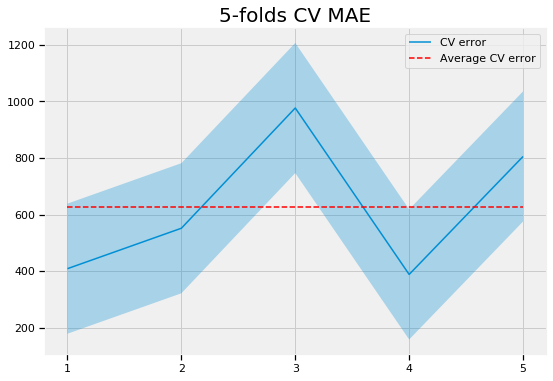

In [11]:
utils.plot_cv_error(cv_error, metric_name='MAE', figsize=(8, 6))

# EDA

In [12]:
# EDA
df.describe()

,bathrooms,bedrooms,longitude,latitude,price
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04
mean,1.21218,1.541640,-73.955716,40.741545,3.830174e+03
std,0.50142,1.115018,1.177912,0.638535,2.206687e+04
min,0.00000,0.000000,-118.271000,0.000000,4.300000e+01
25%,1.00000,1.000000,-73.991700,40.728300,2.500000e+03
50%,1.00000,1.000000,-73.977900,40.751800,3.150000e+03
75%,1.00000,2.000000,-73.954800,40.774300,4.100000e+03
max,10.00000,8.000000,0.000000,44.883500,4.490000e+06


In [13]:
df.bathrooms.value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
10.0        1
7.0         1
Name: bathrooms, dtype: int64

In [14]:
df.bedrooms.value_counts()

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
8        2
7        2
Name: bedrooms, dtype: int64

In [15]:
df.price.sort_values(ascending=False).head(10)

19558    4490000
9590     1150000
30689    1070000
29665    1070000
10581     135000
25538     111111
45674     100000
29082      90000
7336       85000
47995      80000
Name: price, dtype: int64

- Looks like the majority of the apartments have less than 6 bedrooms and/or 6 bathrooms.
- Also, looks like $4,490,000 rent/month is an outlier.
- Moreover, most likely longitude 0 and latitude 0 are errors.

In [16]:
df.isnull().sum()

bathrooms    0
bedrooms     0
longitude    0
latitude     0
price        0
dtype: int64

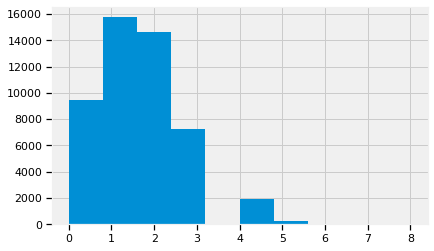

In [17]:
plt.hist(df.bedrooms);

In [18]:
# Create clean df that excludes prices < 1000 and prices > 10000
df_clean = df[(df.price > 1000) & (df.price < 10000)]

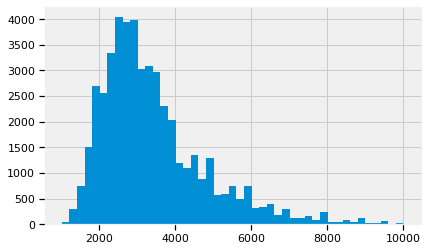

In [19]:
plt.hist(df_clean.price, bins=45);

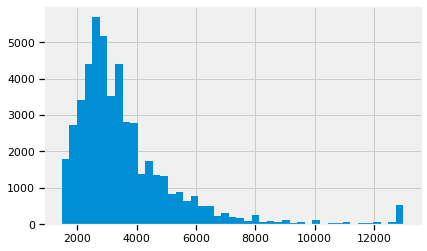

In [20]:
# Exclude examples from both top/bottom 1%
lower, upper = np.percentile(df.price, [1, 99])
price_clipped = np.clip(df.price, lower, upper)
plt.hist(price_clipped, bins=45);

In [21]:
# Create clean df that excludes prices < 1000 and prices > 10000
df_clean = df[(df.price > 1000) & (df.price < 10000)]

# Include only the data for NY using gps coordinates
df_clean = df_clean[(df.longitude != 0) | (df.latitude != 0)]
df_clean = df_clean[(df_clean['latitude'] > 40.55) & (df_clean['latitude'] < 40.94) &
                    (df_clean['longitude'] > -74.1) & (df_clean['longitude'] < -73.67)]

# Split the data
df_train, df_test = train_test_split(df_clean, test_size=0.15)

# Separate features and target
X_train = df_train[['bathrooms', 'bedrooms', 'longitude', 'latitude']]
y_train = df_train['price']
X_test = df_test[['bathrooms', 'bedrooms', 'longitude', 'latitude']]
y_test = df_test['price']

/Users/imad/anaconda3/envs/ml-zoo/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [23]:
# Run k-folds CV to get a better estimates of MAE
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
k = 5
cv_error = -cross_val_score(rf,
                            X_train, y_train,
                            cv=k,
                            scoring='neg_mean_absolute_error',
                            n_jobs=-1)

# Avg and std of CV error
avg_cv_error = cv_error.mean()
std_cv_error = cv_error.std()
print(f'{k}-folds CV MAE: ${avg_cv_error:.2f} +/- ${std_cv_error:.2f}')

5-folds CV MAE: $303.42 +/- $2.54


Got a lot lower mean CV error with also much less variability with only $4.56 std

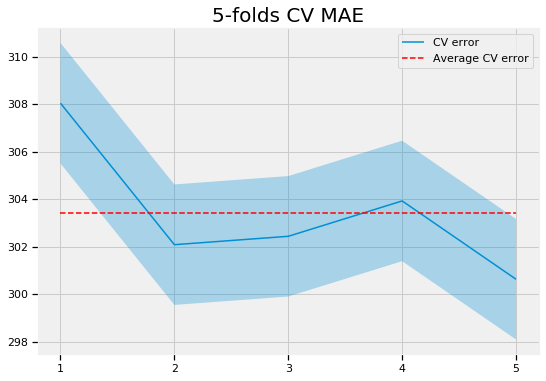

In [24]:
# Plot CV error
utils.plot_cv_error(cv_error, metric_name='MAE', figsize=(8, 6))

In [25]:
# Use OOB R2
rf = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
utils.compute_stable_oob_score(rf, X_train, y_train, metric_name='R2')

average OOB R2 : 0.8618 +/- 0.0004


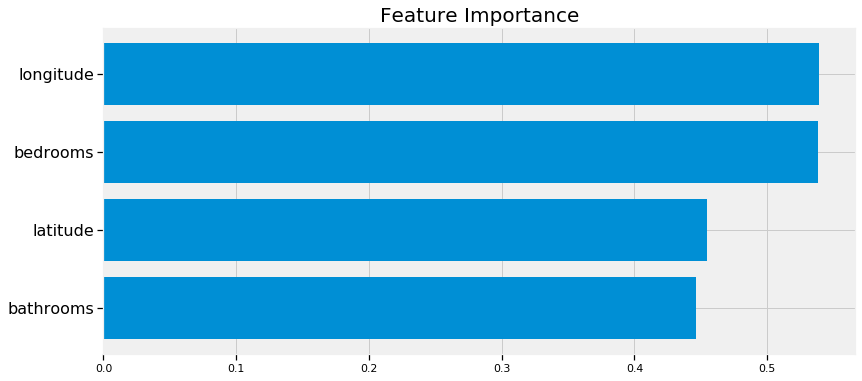

In [26]:
utils.plot_feature_imp_v1(
    rf, X_train.values, y_train.values, X_train.columns, mode='permutation')

In [27]:
# Build Lasso model as a baseline model
lm = Lasso(alpha=0.5)
lm.fit(X_train, y_train)
print(f'training score : {lm.score(X_train, y_train):.4f}')

training score : 0.5751


A lot less than R2 from RF model. Means Lasso can't capture relationship

In [28]:
# Measure how confident the ensemble is in predicting individual examples
X_test = df_test[['bathrooms', 'bedrooms', 'longitude', 'latitude']]
y_test = df_test['price']
for i in range(1, 11):
    preds = np.array([tree.predict([X_test.iloc[i]])
                      for tree in rf.estimators_])
    avg = preds.mean()
    std = preds.std()
    y = y_test.iloc[i]
    print(
        f'Apt {i:>2} : true price = ${y}, predicted price = ${avg:.0f} +/- ${std:.0f}')

Apt  1 : true price = $3780, predicted price = $3987 +/- $85
Apt  2 : true price = $2960, predicted price = $3058 +/- $76
Apt  3 : true price = $3650, predicted price = $3328 +/- $348
Apt  4 : true price = $2575, predicted price = $2602 +/- $178
Apt  5 : true price = $1650, predicted price = $1687 +/- $152
Apt  6 : true price = $3450, predicted price = $4317 +/- $666
Apt  7 : true price = $3475, predicted price = $4842 +/- $320
Apt  8 : true price = $2895, predicted price = $2276 +/- $39
Apt  9 : true price = $2000, predicted price = $1990 +/- $12
Apt 10 : true price = $4200, predicted price = $4116 +/- $34


Looks like std for predictions of individual samples are unstable.

In [29]:
# Reimport the data to get additional fields
df = pd.read_csv('../data/rent.csv')
df = df[['bathrooms', 'bedrooms', 'longitude', 'latitude', 'features', 'price']]
# Create clean df that excludes prices < 1000 and prices > 10000
df_clean = df[(df.price > 1000) & (df.price < 10000)]

# Include only the data for NY using gps coordinates
df_clean = df_clean[(df_clean.longitude != 0) | (df_clean.latitude != 0)]
df_clean = df_clean[(df_clean['latitude'] > 40.55) & (df_clean['latitude'] < 40.94) &
                    (df_clean['longitude'] > -74.1) & (df_clean['longitude'] < -73.67)]

df_clean.head()

,bathrooms,bedrooms,longitude,latitude,features,price
0,1.5,3,-73.9425,40.7145,[],3000
1,1.0,2,-73.9667,40.7947,"['Doorman', 'Elevator', 'Fitness Center', 'Cat...",5465
2,1.0,1,-74.0018,40.7388,"['Laundry In Building', 'Dishwasher', 'Hardwoo...",2850
3,1.0,1,-73.9677,40.7539,"['Hardwood Floors', 'No Fee']",3275
4,1.0,4,-73.9493,40.8241,['Pre-War'],3350


In [30]:
# Fill NA for features col and convert it to lower
df_clean['features'] = df_clean.features.fillna('')
df_clean['features'] = df_clean.features.str.lower()

# Add three features
df_clean['doorman'] = df_clean['features'].str.contains('doorman')
df_clean['laundry'] = df_clean['features'].str.contains('laundry')
df_clean['parking'] = df_clean['features'].str.contains('parking|garage')
df_clean = df_clean.drop(columns=['features'])
df_clean.head()

,bathrooms,bedrooms,longitude,latitude,price,doorman,laundry,parking
0,1.5,3,-73.9425,40.7145,3000,False,False,False
1,1.0,2,-73.9667,40.7947,5465,True,False,False
2,1.0,1,-74.0018,40.7388,2850,False,True,False
3,1.0,1,-73.9677,40.7539,3275,False,False,False
4,1.0,4,-73.9493,40.8241,3350,False,False,False


In [31]:
# Split the data
df_train, df_test = train_test_split(df_clean, test_size=0.15)

# Separate features and target
X_train = df_train.drop(columns='price', axis=1)
y_train = df_train['price']
X_test = df_test.drop(columns='price', axis=1)
y_test = df_test['price']

In [32]:
# Use OOB R2
rf = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
print(f' OOb R2 : {rf.oob_score_:.4f}')

 OOb R2 : 0.8631


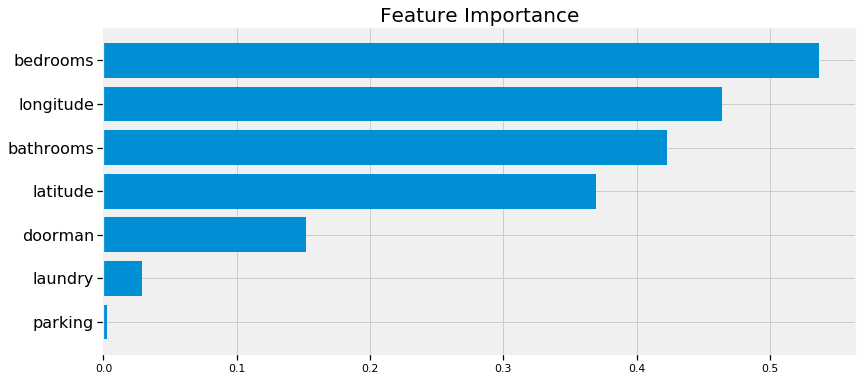

In [33]:
utils.plot_feature_imp_v1(
    rf, X_train.values, y_train.values, X_train.columns, mode='permutation')

In [34]:
utils.compute_stable_oob_score(rf, X_train, y_train, metric_name='R2')

average OOB R2 : 0.8631 +/- 0.0002


In [35]:
# Drop parking
utils.compute_stable_oob_score(rf, X_train.drop(columns=['parking'], axis=1), y_train, metric_name='R2')

average OOB R2 : 0.8621 +/- 0.0005


We may want to leave parking.